In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from nlgcg_parameter_free import NLGCGParameterFree

# Heat Equation

## Generate Data and Define Functions

In [17]:
# Omega = np.array([[0,1], [0,1]])
# alpha = 1e-1
# observation_resolution = 4
# std_factor = 0.1
# true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
# true_weights = np.array([1,-0.7, 0.8])

In [18]:
Omega = np.array([[0,1], [0,1]])
alpha = 2e-1
observation_resolution = 10
std_factor = 0.02
np.random.seed(49)
true_sources = np.random.rand(20, 2)*0.9
true_weights = np.random.rand(20) * 2 - 1

In [19]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [20]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [21]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [22]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [23]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [24]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [25]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [26]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [27]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [28]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [29]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

## Experiments

In [30]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           global_search_resolution=100,
           dual_variable_goodness=0.3
           )

In [31]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-6, max_radius=0.1)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:0: choice: 0, lazy: True, support: 0, epsilon: 0.1, c_raw: 1024.0, objective: 3.049829E+03
INFO:root:=============================================================================================
INFO:root:Radii: [0.1]
INFO:root:1, 1: Globalization: Newton, support: 1, epsilon: 0.1, c_raw: 1024.0 objective: 2.088018E+03
INFO:root:-1.241179477127389
INFO:root:1, 2: Globalization: Newton, support: 1, epsilon: 0.1, c_raw: 1024.0 objective: 2.086777E+03
INFO:root:-0.0004987015640836034
INFO:root:1, 3: Globalization: Newton, support: 1, epsilon: 0.1, c_raw: 1024.0 objective: 2.086776E+03
INFO:root:-5.32054400537163e-11
INFO:root:1, 4: Globalization: Newton, support: 1, epsilon: 0.1, c_raw: 1024.0 objective: 2.086776E+03
INFO:root:gap: 7.673703463094477e-11, norm grad: 2.845115269637014e-10
INFO:root:gap: 7.673703463094477e-11, norm grad: 2.845115269637014e-10
INFO:root:Descent test: False
DEBUG:root:SSN

In [32]:
u.support

array([[0.10591198, 0.64338505],
       [0.11236112, 0.40185069],
       [0.2259625 , 0.81987075],
       [0.22596286, 0.81986847],
       [0.22596523, 0.81987349],
       [0.2563949 , 0.2850921 ],
       [0.25681539, 0.28561012],
       [0.25694726, 0.28564324],
       [0.27251008, 0.06300024],
       [0.27251804, 0.06299928],
       [0.29539077, 0.33311046],
       [0.29613648, 0.33416155],
       [0.32530055, 0.38536292],
       [0.32538517, 0.385365  ],
       [0.4042744 , 0.72180838],
       [0.41009725, 0.4795279 ],
       [0.48400949, 0.18907121],
       [0.48404532, 0.18906727],
       [0.48405986, 0.18905778],
       [0.54894218, 0.16910193],
       [0.54898672, 0.16907371],
       [0.55956803, 0.97665592],
       [0.60300678, 0.63482032],
       [0.60317731, 0.63476517],
       [0.60537778, 0.36886862],
       [0.60538437, 0.36886749],
       [0.62136242, 0.80830464],
       [0.65549462, 0.45212855],
       [0.65554955, 0.45210023],
       [0.65557279, 0.45218889],
       [0.

In [27]:
hesses = exp.hess_P(u)(u.support)
grads = exp.grad_P(u)(u.support)

In [26]:
np.linalg.eigvals(hesses[5])

array([-7.10351231e+01, -6.13832992e-02])

In [36]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eigvals(hess)

array([5.37165193e+04, 5.55575634e+04, 2.26370794e+04, 1.82197855e+04,
       1.47474125e+04, 1.31036545e+04, 9.33414586e+03, 6.92049507e+03,
       6.13984123e+03, 5.74280633e+03, 5.49531416e+03, 5.15080869e+03,
       4.61020760e+03, 4.37987892e+03, 3.44423058e+03, 2.11641383e+03,
       1.59819959e+03, 1.39305329e+03, 1.29810707e+03, 9.37323141e+02,
       9.01012355e+02, 6.88129423e+02, 6.00662894e+02, 5.13149369e+02,
       4.63082339e+02, 3.49602197e+02, 2.92488954e+02, 1.77335855e+02,
       1.68570853e+02, 1.34953489e+02, 1.10787631e+02, 8.28657333e+01,
       7.69867710e+01, 6.70429826e+01, 6.50425758e+01, 3.69456407e+01,
       3.25063792e+01, 2.14150514e+01, 2.00008471e+01, 1.71940528e+01,
       1.32139825e+01, 8.08679652e+00, 6.71134089e+00, 5.28341997e+00,
       4.41111729e+00, 3.74892269e+00, 3.10170608e+00, 2.01187358e+00,
       1.75010412e+00, 1.43561691e+00, 9.61937009e-01, 9.38767501e-01,
       7.23806738e-01, 6.79700671e-01, 5.22725969e-01, 5.05864535e-01,
      

## Plots

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7fda88a58760>


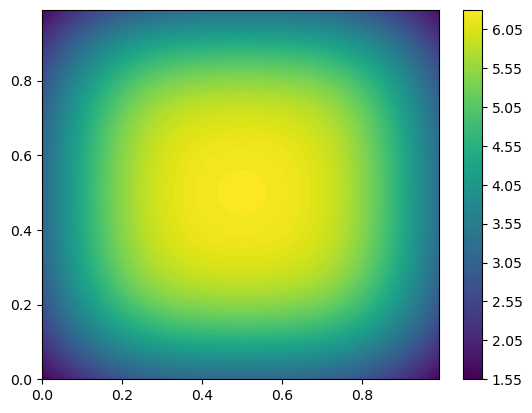

In [18]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
p_u = p(u_tilde)
fct = lambda x: np.linalg.norm(kappa(x), axis=1)
a = np.arange(0,1,0.01)
x, y = np.meshgrid(a,a)
points = np.array(list(zip(x.flatten(), y.flatten())))
vals = fct(points).reshape((100,100))

plt.contourf(x, y, vals, levels=100);
plt.colorbar();

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f583016dc60>


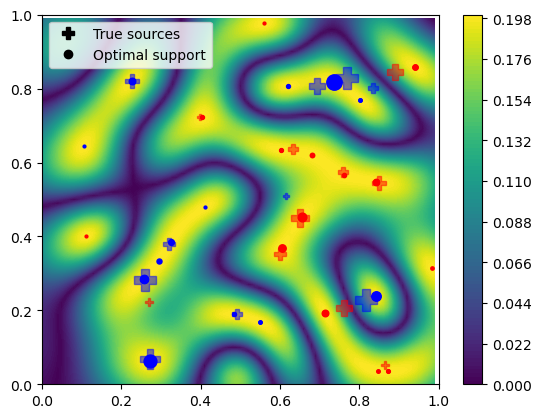

In [34]:
p_u = p(u)
P = lambda x: np.abs(p_u(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
plt.plot(Omega[0][0]-1, Omega[0][1]-1, "P", c="black", markersize=8, label="True sources");
plt.plot(Omega[0][0]-1, Omega[0][1]-1, "o", c="black", label="Optimal support");
plt.xlim(Omega[0][0], Omega[0][1]);
plt.ylim(Omega[1][0], Omega[1][1]);
for i, x in enumerate(true_sources):
    if true_weights[i] < 0:
        color = "b"
    else:
        color = "r"
    size = abs(true_weights[i]) * 12 + 4
    plt.plot([x[0]], [x[1]], "P", alpha=0.5, c=color, markersize=size);
for i, x in enumerate(u.support):
    if u.coefficients[i] < 0:
        color = "b"
    else:
        color = "r"
    size = abs(u.coefficients[i]) * 10 + 2
    plt.plot([x[0]], [x[1]], "o", c=color, markersize=size);
plt.legend();

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f58180cb4c0>


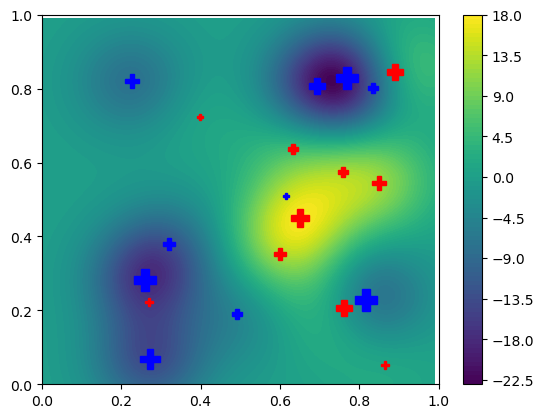

In [35]:
# Plot the measured heat distribution
def heat(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1) 
    weighted_heat = np.zeros(x.shape[0]) # (len(x),)
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point, weight in zip(true_sources, true_weights):
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        weighted_heat += exponentiated * weight # (len(x),)
    result = weighted_heat/outer_factor # shape=(len(x),)
    return result

a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
x = np.array(list(zip(B.flatten(), D.flatten())))
true_vals = heat(x).reshape((100,100))

plt.contourf(B, D, true_vals, levels=100);
plt.colorbar();
plt.xlim(Omega[0][0], Omega[0][1]);
plt.ylim(Omega[1][0], Omega[1][1]);
for i, x in enumerate(true_sources):
    if true_weights[i] < 0:
        color = "b"
    else:
        color = "r"
    size = abs(true_weights[i]) * 12 + 4
    plt.plot([x[0]], [x[1]], "P", c=color, markersize=size);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f581821cbb0>


L2 error: 8.404E-02, Linf error: 1.014E+00


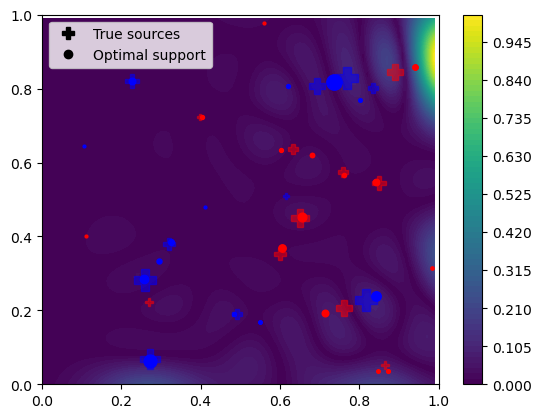

In [36]:
def predicted_heat(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1) 
    weighted_heat = np.zeros(x.shape[0]) # (len(x),)
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point, weight in zip(u.support, u.coefficients):
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        weighted_heat += exponentiated * weight # (len(x),)
    result = weighted_heat/outer_factor # shape=(len(x),)
    return result

a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
x = np.array(list(zip(B.flatten(), D.flatten())))
pred_vals = predicted_heat(x).reshape((100,100))
error = true_vals - pred_vals

print(f"L2 error: {np.linalg.norm(error)/np.sqrt(len(x)):.3E}, Linf error: {np.max(np.abs(error)):.3E}")

plt.contourf(B, D, np.abs(error), levels=100);
plt.colorbar();
plt.plot(Omega[0][0]-1, Omega[0][1]-1, "P", c="black", markersize=8, label="True sources");
plt.plot(Omega[0][0]-1, Omega[0][1]-1, "o", c="black", label="Optimal support");
plt.xlim(Omega[0][0], Omega[0][1]);
plt.ylim(Omega[1][0], Omega[1][1]);
for i, x in enumerate(true_sources):
    if true_weights[i] < 0:
        color = "b"
    else:
        color = "r"
    size = abs(true_weights[i]) * 12 + 4
    plt.plot([x[0]], [x[1]], "P", alpha=0.5, c=color, markersize=size);
for i, x in enumerate(u.support):
    if u.coefficients[i] < 0:
        color = "b"
    else:
        color = "r"
    size = abs(u.coefficients[i]) * 10 + 2
    plt.plot([x[0]], [x[1]], "o", c=color, markersize=size);
plt.legend();

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
# alpha = 1e-0
# observation_resolution = 100
# Omega = np.array([[0,observation_resolution//2]])
# np.random.seed(49)
# true_sources = np.random.rand(10)*50
# true_weights = np.random.rand(10) * 2 - 1

In [4]:
observations = np.arange(0,1,1/observation_resolution)

In [5]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [6]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [7]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [8]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [9]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [10]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [11]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [12]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [13]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [14]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

## Experiments

In [15]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           global_search_resolution=1000
           )

In [16]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-6, max_radius=1)

DEBUG:root:SSN in 3 dimensions converged in 11 iterations to tolerance 1.000E-12
INFO:root:0: choice: 0, lazy: True, support: 0, epsilon: 0.05, c_raw: 64.0, objective: 5.291269E+01
INFO:root:=============================================================================================
INFO:root:Radii: [1, 1, 1]
INFO:root:1, 1: Globalization: Newton, support: 3, epsilon: 0.05, c_raw: 64.0 objective: 6.571119E-01
INFO:root:1, 2: Globalization: Newton, support: 3, epsilon: 0.05, c_raw: 64.0 objective: 2.230934E-01
INFO:root:1, 3: Globalization: Newton, support: 3, epsilon: 0.05, c_raw: 64.0 objective: 2.197539E-01
INFO:root:1, 4: Globalization: Newton, support: 3, epsilon: 0.05, c_raw: 64.0 objective: 2.197539E-01
INFO:root:gap: 1.8324946563240552e-06, norm grad: 1.2171487214153972e-07


In [17]:
np.array(times)

array([2.38418579e-07, 4.04634476e-02, 5.74135780e-02, 7.20136166e-02,
       8.61673355e-02, 1.00032091e-01, 3.60457897e-01])

In [18]:
dropped_tot

0

In [19]:
u.coefficients

array([-0.99832728,  0.69841291,  0.49833707])

In [71]:
u.support

array([[10.52097383],
       [12.34901684],
       [12.34901684],
       [15.04806774],
       [15.04806774],
       [27.34830249],
       [28.34417315],
       [34.16365339],
       [38.48863726],
       [41.78876537],
       [42.32764625],
       [42.86390143],
       [43.39990959],
       [43.93716238],
       [44.47754844],
       [45.02487501],
       [45.59095948],
       [46.27078655],
       [46.83877116],
       [46.83877116],
       [47.5204258 ],
       [48.08948812],
       [48.64085163],
       [49.18625537]])

## Plots

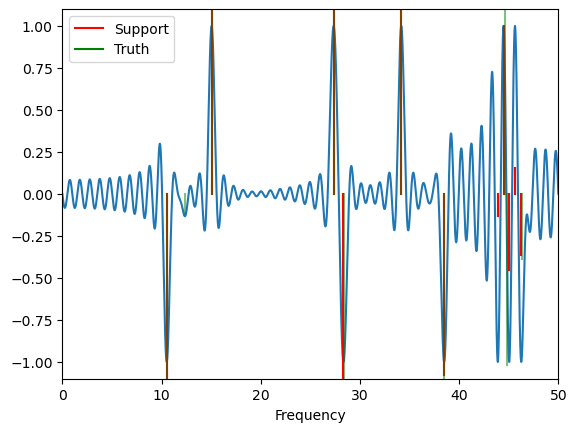

In [133]:
a = np.arange(Omega[0][0],Omega[0][1],0.001)
p_u = p(u)
vals = p_u(a)
plt.plot(a,vals);
plt.axvline(x=-1, linestyle="-", c="r", label="Support");
plt.axvline(x=-1, linestyle="-", c="g", label="Truth");
for i, pos in enumerate(u.support):
    ymax = 0.5+(u.coefficients[i]*alpha*1.1+0.05*np.sign(u.coefficients[i]))
    plt.axvline(x=pos, ymin=0.5,ymax=ymax, linestyle="-", c="r");
for point, weight in  zip(true_sources, true_weights):
    ymax = 0.5+(weight*alpha*1.1+0.05*np.sign(weight))
    plt.axvline(x=point, ymin=0.5,ymax=ymax,alpha=0.5, linestyle="-", c="g");
plt.xlabel("Frequency");
plt.ylim(-alpha*1.1,alpha*1.1);
plt.xlim(0, 50);
plt.legend();

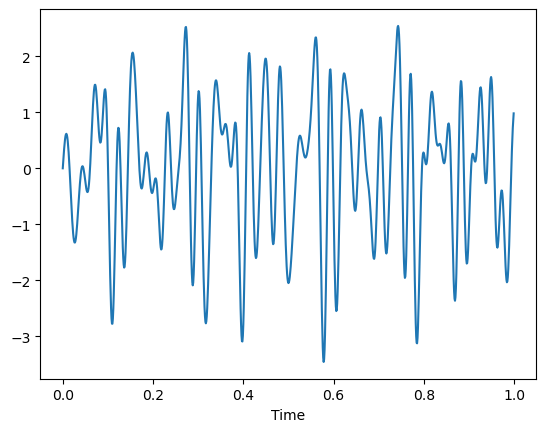

In [134]:
# Plot the measured heat distribution
def signal(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    weighted_signal = 0
    for point, weight in zip(true_sources, true_weights):
        weighted_signal += weight*np.sin(2*np.pi*point*x).flatten()
    return weighted_signal

a = np.arange(0,1,0.001)
true_signal = signal(a)
plt.plot(a, true_signal);
plt.xlabel("Time");

L2 error: 0.046177485674625394, Linf error: 0.14977562862948224


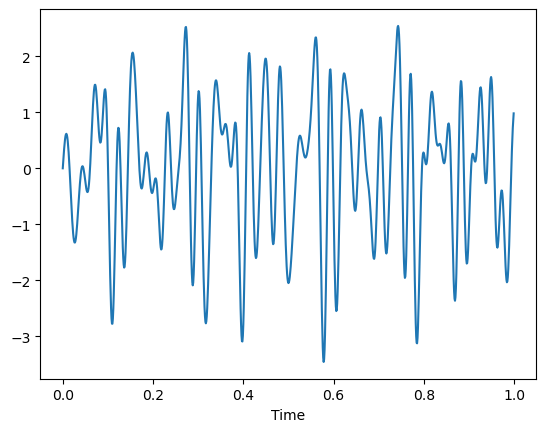

In [135]:
# Plot the measured heat distribution
def signal(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    weighted_signal = 0
    for point, weight in zip(u.support, u.coefficients):
        weighted_signal += weight*np.sin(2*np.pi*point*x).flatten()
    return weighted_signal

a = np.arange(0,1,0.001)
predicted_signal = signal(a)
error = true_signal - predicted_signal
print(f"L2 error: {np.linalg.norm(error)/np.sqrt(len(a))}, Linf error: {np.max(np.abs(error))}")
plt.plot(a, true_signal);
plt.xlabel("Time");

# Function Approximation (sigmoid shallow NN)

## Generate Data and Define Functions

In [61]:
alpha = 1e-6

In [62]:
# Function approximation
observation_size = 100
observation_space = np.array([[0,1], [0,1]])
Omega = np.array([[0,1], [0,1], [0,1]])
true_function = lambda x: np.sin(10*(x[0]**2+x[1]**2))

np.random.seed(49)
columns = []
for bounds in observation_space:
    columns.append(
        np.random.sample((observation_size, 1)) * (bounds[1] - bounds[0]) + bounds[0]
    )
observations = np.concatenate(columns, axis=1)
observations_bias = np.append(np.ones((observations.shape[0],1)),observations,axis=1)
target = np.array([true_function(x) for x in observations])

In [63]:
activation = lambda omega: 1/(1+np.exp(omega)) # sigmoid
def kappa(x):
    # input is a 2D array of shape (number of points, dimension of observation space +1)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    linear_operation = x@(observations_bias.T)
    activated = activation(linear_operation)
    return activated # shape (len(x), len(observations))

In [64]:
def activation_grad(omega: np.ndarray) -> np.ndarray:
    sigmoid = activation(omega)
    return sigmoid * (1 - sigmoid)  # Derivative of the sigmoid function

def grad_kappa(x):
    # input is a 2D array of shape (number of points, dimension of observation space +1)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    linear_operation = x@(observations_bias.T)
    activated = activation_grad(linear_operation) # shape=(len(x), len(observations))
    inner_derivative = np.repeat(np.expand_dims(observations_bias,axis=0),len(x),axis=0) # shape=(len(x), len(observations), Omega.shape[0])
    chain_rule = np.multiply(activated.reshape((len(x),len(observations),1)), inner_derivative)
    return chain_rule # shape (len(x), len(observations), Omega.shape[0])

In [65]:
def activation_hess(omega: np.ndarray) -> np.ndarray:
    sigmoid = activation(omega)
    return sigmoid * (1 - sigmoid)*(1-2*sigmoid)  # Derivative of the sigmoid function

def hess_kappa(x):
    # Input is 2D array of shape (number of points, dimension of observation space +1)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    linear_operation = x@(observations_bias.T)
    activated = activation_hess(linear_operation)
    inner_second_derivative_raw = np.array([np.outer(vect, vect) for vect in observations_bias]) # shape (len(observations),Omega.shape[0],Omega.shape[0])
    inner_second_derivative = np.repeat(np.expand_dims(inner_second_derivative_raw,axis=0),len(x),axis=0) # shape (len(x),len(observations),Omega.shape[0],Omega.shape[0])
    chain_rule = np.multiply(activated.reshape((len(x),len(observations),1,1)), inner_second_derivative)
    return chain_rule # shape (len(x), len(observations), Omega.shape[0], Omega.shape[0])

In [66]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [67]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [68]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [69]:
def grad_P_raw_sphere(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    def grad_P_x(x):
        unprojected = np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))
        to_return = np.zeros(unprojected.shape)
        for i, (grad ,position) in enumerate(zip(unprojected, x)):
            # Project onto the ball
            projection = np.eye(len(position)) - np.outer(position, position)
            to_return[i] = projection@grad
        return to_return
    return grad_P_x

grad_P_sphere = lambda u: grad_P_raw_sphere(u)

In [70]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [71]:
def hess_P_raw_sphere(u):
    p_u = p_raw(u)
    grad_u = grad_P(u)
    inner = target-u.duality_pairing(kappa)
    def hess_P_x(x):
        grads = grad_u(x)
        unprojected = np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))
        to_return = np.zeros(unprojected.shape)
        for i, (grad, hess, position) in enumerate(zip(grads, unprojected, x)):
            # P_x(hess-position.T*grad*I)
            projection = np.eye(len(position)) - np.outer(position, position)
            identity_factor = position@grad
            to_return[i] = projection@(hess-identity_factor*np.eye(len(position)))@projection
        return to_return
    return hess_P_x

hess_P_sphere = lambda u: hess_P_raw_sphere(u)

In [72]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [73]:
def grad_j_sphere(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    for i, (grad ,position) in enumerate(zip(nabla_x, positions)):
        # Project onto the ball
        nabla_x[i] = (np.eye(len(position))-np.outer(position, position))@grad
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [74]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [75]:
def hess_j_sphere(positions, coefs):
    hessian = hess_j(positions, coefs)
    gradient = grad_j(positions, coefs)
    projection = np.eye(hessian.shape[0])
    inner_matrix = np.eye(hessian.shape[0])
    for i, position in enumerate(positions):
        projection_part = np.eye(len(position))-np.outer(position, position)
        inner_matrix_part = (position@gradient[i*len(position):(i+1)*len(position)])*np.eye(len(position))
        projection[i*len(position):(i+1)*len(position), i*len(position):(i+1)*len(position)] = projection_part
        inner_matrix[i*len(position):(i+1)*len(position), i*len(position):(i+1)*len(position)] = inner_matrix_part
    hesse_system = projection@(hessian-inner_matrix)@projection
    return hesse_system

## Experiments

In [76]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P_sphere,
           hess_P=hess_P_sphere,
           grad_j=grad_j_sphere,
           hess_j=hess_j_sphere,
           alpha=alpha,
           Omega=Omega,
           global_search_resolution=100,
           dual_variable_goodness=0.3,
           projection="sphere"
           )

In [77]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-12, max_radius=0.1)

INFO:root:Radii: []
DEBUG:root:SSN in 181 dimensions converged in 11 iterations to tolerance 1.000E-12
INFO:root:0: choice: 0, lazy: True, support: 0, epsilon: 1.3209093658606576e-05, c_raw: 8192.0, objective: 2.641819E+01
INFO:root:=============================================================================================
INFO:root:Radii: [0.1]
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 1.3209093658606576e-05, c_raw: 8192.0 objective: 2.617532E+01
INFO:root:norm_grad: 0.03166117765420083, constant: 0.010389193788632607, diff: 0.07478477022451457, smallest eival: -1.768E-01, largest eival: 2.406E+01
INFO:root:Inequalities 6.6: [False, True, False]
DEBUG:root:SSN in 5 dimensions converged in 19 iterations to tolerance 1.000E-12
INFO:root:1: choice: 0, lazy: True, support: 1, epsilon: 1.3209093658606576e-05, c_raw: 4096.0, objective: 2.617532E+01
INFO:root:=============================================================================================
INFO:root:Radii: [0.1, 0.1, 0.1]

KeyboardInterrupt: 

## Plots

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f4c41b2e020>


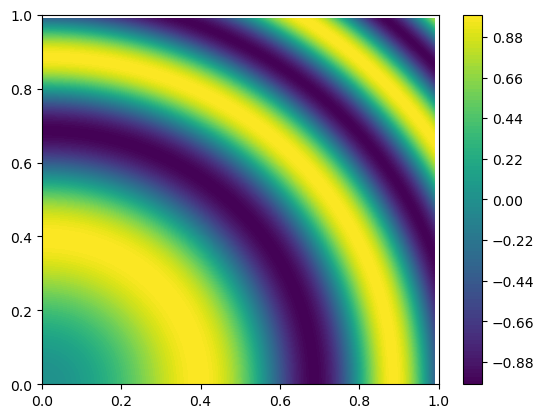

In [60]:
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
X = np.array(list(zip(B.flatten(), D.flatten())))
true_vals = np.array([true_function(x) for x in X]).reshape((100,100))

plt.contourf(B, D, true_vals, levels=100);
plt.colorbar();
plt.xlim(Omega[0][0], Omega[0][1]);
plt.ylim(Omega[1][0], Omega[1][1]);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f4c4365c670>


L2 error: 6.382E-03, Linf error: 2.641E-02


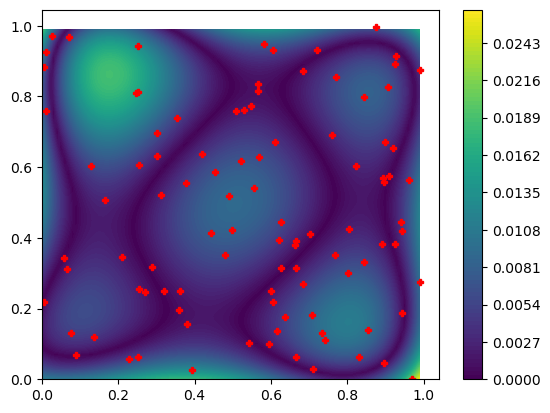

In [44]:
def predicted(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    x_bias = np.append(np.ones((x.shape[0],1)),x,axis=1)
    activated = activation(x_bias@u.support.T) # shape (len(x), len(observations))
    output = np.dot(activated, u.coefficients) # shape (len(x),)
    return output

a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
x = np.array(list(zip(B.flatten(), D.flatten())))
pred_vals = predicted(x).reshape((100,100))
error = true_vals - pred_vals

print(f"L2 error: {np.linalg.norm(error)/np.sqrt(len(x)):.3E}, Linf error: {np.max(np.abs(error)):.3E}")

plt.contourf(B, D, np.abs(error), levels=100);
plt.colorbar();
for i, x in enumerate(observations):
    plt.plot([x[0]], [x[1]], "P", c="r", markersize=4);